In [2]:
import sys
import os
import pandas as pd
import gzip
import bz2
import numpy as np
import jax
import jax.numpy as jnp
import time
import pylab as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

## Covtype: https://archive.ics.uci.edu/ml/datasets/covertype

In [3]:
covtype_path = "data/covtype.data.gz"

covtype_np = np.loadtxt(covtype_path, delimiter=',')
print(covtype_np.shape)

(581012, 55)


In [4]:
covtype_feature = covtype_np[:,:-1]
covtype_label = covtype_np[:,-1].reshape(-1,1).astype(int)
covtype_label = covtype_label - 1

print(covtype_feature.shape)
print(covtype_label.shape)

(581012, 54)
(581012, 1)


In [5]:
print(pd.DataFrame(np.unique(covtype_label, return_counts=True)).T)

   0       1
0  0  211840
1  1  283301
2  2   35754
3  3    2747
4  4    9493
5  5   17367
6  6   20510


In [6]:
covtype_feature_train, covtype_feature_test, covtype_label_train, covtype_label_test = \
    train_test_split(covtype_feature, covtype_label, random_state=4212)

In [7]:
print(covtype_feature_train.shape)
print(covtype_label_train.shape)
print(covtype_feature_test.shape)
print(covtype_label_test.shape)

(435759, 54)
(435759, 1)
(145253, 54)
(145253, 1)


In [8]:
covtype_df = pd.DataFrame(covtype_feature)

covtype_df.iloc[:,:10].describe()

,0,1,2,3,4,5,6,7,8,9
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000


In [9]:
num_attribs = np.arange(0,10,1)
cat_attribs = np.arange(10,54,1)

full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_attribs),
    ],remainder='passthrough')

covtype_feature_train_norm = full_pipeline.fit_transform(covtype_feature_train)
covtype_feature_test_norm = full_pipeline.transform(covtype_feature_test)
print(covtype_feature_train_norm.shape)
print(covtype_feature_test_norm.shape)

(435759, 54)
(145253, 54)


## IJCNN https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#ijcnn1

In [82]:
from sklearn.datasets import load_svmlight_file

filepath = 'data/ijcnn1.tr.bz2'
ijcnn_train_data, ijcnn_train_label = load_svmlight_file(filepath)
filepath = 'data/ijcnn1.val.bz2'
ijcnn_val_data, ijcnn_val_label = load_svmlight_file(filepath)
filepath = 'data/ijcnn1.t.bz2'
ijcnn_test_data, ijcnn_test_label = load_svmlight_file(filepath)

ijcnn_train_data = ijcnn_train_data.toarray()
ijcnn_val_data = ijcnn_val_data.toarray()
ijcnn_test_data = ijcnn_test_data.toarray()

In [89]:
temp = np.concatenate((ijcnn_train_data, ijcnn_val_data))
temp_label = np.concatenate((ijcnn_train_label, ijcnn_val_label))
ijcnn_train_data = temp
ijcnn_train_label = temp_label

In [93]:
ijcnn_train_label = ijcnn_train_label.astype(int)
ijcnn_test_label = ijcnn_test_label.astype(int)
ijcnn_train_label = (ijcnn_train_label+1) // 2
ijcnn_test_label = (ijcnn_test_label+1) // 2

In [94]:
print(ijcnn_train_data.shape)
print(ijcnn_train_label.shape)
print(ijcnn_test_data.shape)
print(ijcnn_test_label.shape)

(49990, 22)
(49990,)
(91701, 22)
(91701,)


In [95]:
print(ijcnn_train_data.max())
print(ijcnn_train_data.min())
# Already Scaled

1.0
-0.930435


## MNIST: http://yann.lecun.com/exdb/mnist/

In [14]:
def training_images():
    with gzip.open('data/train-images-idx3-ubyte.gz', 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8)\
            .reshape((image_count, row_count, column_count))
        return images


def training_labels():
    with gzip.open('data/train-labels-idx1-ubyte.gz', 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels.reshape(-1,1)
    
def test_images():
    with gzip.open('data/t10k-images-idx3-ubyte.gz', 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8)\
            .reshape((image_count, row_count, column_count))
        return images


def test_labels():
    with gzip.open('data/t10k-labels-idx1-ubyte.gz', 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels.reshape(-1,1)

In [15]:
mnist_train_images = training_images()
mnist_train_labels = training_labels()
print(mnist_train_images.shape)
print(mnist_train_labels.shape)

(60000, 28, 28)
(60000, 1)


In [16]:
mnist_test_images = test_images()
mnist_test_labels = test_labels()
print(mnist_test_images.shape)
print(mnist_test_labels.shape)

(10000, 28, 28)
(10000, 1)


In [17]:
print(pd.DataFrame(np.unique(mnist_train_labels, return_counts=True)).T)

   0     1
0  0  5923
1  1  6742
2  2  5958
3  3  6131
4  4  5842
5  5  5421
6  6  5918
7  7  6265
8  8  5851
9  9  5949


In [18]:
print(np.max(mnist_train_images))
print(np.max(mnist_test_images))

255
255


In [19]:
mnist_train_images = mnist_train_images / 255.
mnist_test_images = mnist_test_images / 255.

## Adult: https://archive.ics.uci.edu/ml/datasets/adult

In [20]:
## Need further data cleaning & manipulating

adult_train = "data/adult.data"
adult_test = "data/adult.test"
adult_train_df = pd.read_csv(adult_train, header=None)
adult_test_df = pd.read_csv(adult_test, index_col=None)
adult_test_df = adult_test_df.reset_index()

In [21]:
adult_col_names = ['age','workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation','relationship','race','sex','capital-gain','capital-loss', 'hours-per-week','native-country', 'salary']
adult_train_df.columns = adult_col_names
adult_test_df.columns = adult_col_names

In [22]:
adult_feature_train = adult_train_df.iloc[:,:-1] 
adult_label_train = adult_train_df.iloc[:,-1]
adult_feature_test = adult_test_df.iloc[:,:-1]
adult_label_test = adult_test_df.iloc[:,-1]

In [23]:
print(adult_feature_train.shape)
print(adult_label_train.shape)
print(adult_feature_test.shape)
print(adult_label_test.shape)

(32561, 14)
(32561,)
(16281, 14)
(16281,)


In [24]:
adult_feature_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [25]:
print(pd.DataFrame(np.unique(adult_label_train, return_counts=True)).T)
print(pd.DataFrame(np.unique(adult_label_test, return_counts=True)).T)

        0      1
0   <=50K  24720
1    >50K   7841
         0      1
0   <=50K.  12435
1    >50K.   3846


In [26]:
adult_feature_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


In [27]:
num_attribs = adult_feature_train.columns[adult_feature_train.dtypes == 'int64']
cat_attribs = adult_feature_train.columns[adult_feature_train.dtypes == 'object']
print(num_attribs)
print(cat_attribs)

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')
Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')


In [28]:
num_attribs = adult_feature_train.columns[adult_feature_train.dtypes == 'int64']
cat_attribs = adult_feature_train.columns[adult_feature_train.dtypes == 'object']

full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_attribs),
        ("cat", OneHotEncoder(), cat_attribs)
    ])

adult_feature_train_norm = full_pipeline.fit_transform(adult_feature_train)
adult_feature_train_norm = adult_feature_train_norm.toarray()
adult_feature_test_norm = full_pipeline.transform(adult_feature_test)
adult_feature_test_norm = adult_feature_test_norm.toarray()

print(adult_feature_train_norm.shape)
print(adult_feature_test_norm.shape)

(32561, 108)
(16281, 108)


In [29]:
n_train = adult_label_train.shape[0]
n_test = adult_label_test.shape[0]
adult_label_train_bi = np.zeros(n_train)
adult_label_test_bi = np.zeros(n_test)

adult_label_train_bi[adult_label_train == adult_label_train.unique()[1]] = 1
adult_label_test_bi[adult_label_test == adult_label_test.unique()[1]] = 1
adult_label_train_bi = adult_label_train_bi.astype(int)
adult_label_test_bi = adult_label_test_bi.astype(int)
print(pd.DataFrame(np.unique(adult_label_train_bi, return_counts=True)).T)
print(pd.DataFrame(np.unique(adult_label_test_bi, return_counts=True)).T)

   0      1
0  0  24720
1  1   7841
   0      1
0  0  12435
1  1   3846


# Utility Functions

## Common Utility

In [30]:
@jax.jit
def pred_proba(beta, x):
    """ predict the probability vector of x belonging to each class """
    scores = beta@x
    return jnp.exp(scores) / jnp.sum(jnp.exp(scores))

pred_proba_batch = jax.vmap(pred_proba, in_axes=(None, 0)) # Vectorize Predict Function

In [31]:
@jax.jit
def get_label(p):
    pred_label = jnp.argmax(p)
    return pred_label

def get_label_batch(P):
    labels = jax.vmap(get_label,in_axes=[0])(P)
    return labels.reshape(-1,1)
# get_label_batch = jax.vmap(get_label,in_axes=[0])

def get_accuracy(pred_labels, Y):
    """ Compare the predicted probability (p) with the ground truth labels (Y) to get the accuracy """
    return jnp.mean(Y==pred_labels)

def test_acc(beta,test_label, test_data):
    # Memory Problem
    N = test_label.shape[0]
    bs = 100
    
    running_acc=0
    n_mb=0
    
    for i in range(0,N,bs):
        mb_data = test_data[i:i+bs]
        mb_label = test_label[i:i+bs]
        
        mb_pred = pred_proba_batch(beta, mb_data)
        mb_pred_labels = get_label_batch(mb_pred)
        mb_acc = get_accuracy(mb_pred_labels, mb_label)
        
        running_acc += mb_acc
        n_mb += 1
    
    # test_acc = jnp.dot(running_acc, batch_sizes) / jnp.sum(batch_sizes)
    test_acc = running_acc / n_mb
        
    # test_pred = pred_proba_batch(beta, test_data)
    # test_acc = get_accuracy(test_pred, Y_true)
    return test_acc

## Graph Plotting

In [32]:
def record_graph(record_list, key='test_acc_epoch', title="Summary of Results", alpha=0.6, n = None):
    """
    Plot graph of records in the list
    
    Args:
     record_list: List of record (dictionary) as returned by model training functions
     key: Performance metric to be plotted
     n: Number of results to be plotted, full results will be plotted if None
     
    Output:
     Multiple lines of the record on the same graph
    """
    keys = record_list[0].keys()
    if key not in keys:
        print(f'{key} is an invalid key!')
        print(f'Please enter one of the following: {keys}')
        
    plt.figure(figsize=(16,10))
        
    for record in record_list:
        if n == None:
            n = len(record.get(key))
        y = record.get(key)[:n]
        x = np.arange(n)

        labels = record.get('name')
        # if 'var' in key:
        #     labels = ["grad_" + str(i) for i in range(y[0].shape[0])]
            
        plt.plot(x,
                 y, 
                 "-.",
                 alpha=alpha,
                 label=labels)
        plt.xticks(range(n))
    
    plt.legend()
    plt.xlabel(f'{key}'.split('_')[-1])
    plt.ylabel(' '.join(f'{key}'.split('_')[:-1]))
    plt.grid(True)
    plt.title(title)

## Multi-Class Logistic Regression

In [33]:
# Multi-Class Logistic Regression Loss
@jax.jit
def loss_single(beta, x, y):
    """
     Loss of a single data in multi-class Logistic Regression
    input:
     beta: Model parameters of shape [n, p], n = number of classes for label, p = dimension of features
     x: feature variables of shape p
     y: label, a single number indicating which class the data belongs to 
    """
    scores = beta@x
    scores = jnp.exp(scores) / jnp.sum(jnp.exp(scores)) # Softmax
    
    # scores = jax.nn.softmax(scores) # Softmax
    loss = -jnp.log(scores[y]) # Negative Loglikelihood of True Class
    return loss
    
loss_batch = jax.vmap(loss_single,in_axes=[None, 0, 0]) # Vectorize

def loss_LR(beta, X, Y):
    return jnp.mean(loss_batch(beta, X, Y))

def loss_LR_single(beta, x, y):
    loss = loss_single(beta, x, y)
    if loss.shape == ():
        return loss
    return loss[0]

In [34]:
# compute derivates
loss_LR_grad = jax.jit(jax.grad(loss_LR, argnums=0))
loss_LR_values_and_grad = jax.jit(jax.value_and_grad(loss_LR, argnums=0))

loss_LR_single_grad = jax.jit(jax.grad(loss_LR_single, argnums=0))
loss_LR_single_values_and_grad = jax.jit(jax.value_and_grad(loss_LR_single, argnums=0))

### Testing Grad Var Calculation

In [38]:
sum_grad_norm = jnp.zeros(7)
sum_grad_norm_2 = jnp.zeros(7)

In [39]:
print(sum_grad_norm_2)
print(sum_grad_norm)

[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]


In [41]:
n_features = 54
n_classes = 7
np.random.seed(4212)

beta_init = np.random.normal(0,np.sqrt(1/(n_features)), size=[n_classes, n_features])

_, grad1 = loss_LR_values_and_grad(beta_init, covtype_feature_train_norm[:1000], covtype_label_train[:1000])
_, grad2 = loss_LR_values_and_grad(beta_init, covtype_feature_train_norm[1000:2000], covtype_label_train[1000:2000])
print(grad1.shape)
print(grad2.shape)

(7, 54)
(7, 54)


In [44]:
jnp.linalg.norm(grad1,axis=None)

DeviceArray(0.5537594, dtype=float32)

In [42]:
new_grad_norm = jnp.linalg.norm(grad1,axis=1)
sum_grad_norm_2 += new_grad_norm**2
sum_grad_norm += new_grad_norm
print(new_grad_norm)
print(sum_grad_norm_2)
print(sum_grad_norm)

[0.2910855  0.33604226 0.20581408 0.12155367 0.12237841 0.12196509
 0.14834969]
[0.08473077 0.1129244  0.04235943 0.0147753  0.01497648 0.01487548
 0.02200763]
[0.2910855  0.33604226 0.20581408 0.12155367 0.12237841 0.12196509
 0.14834969]


In [82]:
new_grad_norm = jnp.linalg.norm(grad2,axis=1)
sum_grad_norm_2 += new_grad_norm**2
sum_grad_norm += new_grad_norm
print(new_grad_norm)
print(sum_grad_norm_2)
print(sum_grad_norm)

[0.29765373 0.32411075 0.20028992 0.12812023 0.12245059 0.13217106
 0.12537302]
[0.17332852 0.21797217 0.08247548 0.03119009 0.02997062 0.03234467
 0.03772602]
[0.5887393  0.66015303 0.406104   0.2496739  0.244829   0.25413615
 0.2737227 ]


In [84]:
n_update = 2
new_grad_var = sum_grad_norm_2 / n_update - (sum_grad_norm / n_update)**2
print(new_grad_var)

[1.07735395e-05 3.55839729e-05 7.62566924e-06 1.07800588e-05
 1.86264515e-09 2.60416418e-05 1.31981447e-04]


# SGD Algos

## 1. Basic SGD

To calculate variance of gradient estimates: https://stats.stackexchange.com/questions/244352/variance-of-gradient-as-e-g-in-sgd

In [35]:
def train_SGD_single(train_data, train_label, beta_init, lr, loss_fn, grad_fn, verbose = 0, n_run=20, random_state=4212):
    """
     Find optimized beta given train images and train labels using Stochastic Gradient Descent (SGD) with Single Data per update of gradient
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     loss_fn: Function to return the loss value
     grad_fn: Function to return the gradient
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_run: Number of computation of gradient / n, default 100
     
    Outputs:
     beta: The final updated values of beta
     record: A dictionary of performance during training, including 'loss_update', 'test_acc_update', 'grad_var_update'
    """
    N = len(train_data)  # total number of data
    img_indices = np.arange(N)

    loss_history_n = []
    grad_var = []
    
    beta = np.copy(beta_init)
    learning_rate = lr
    
    # Calc norm for each set of beta
    # n_grad = beta_init.shape[0]
    # sum_grad_norm_2 = jnp.zeros(n_grad)
    # sum_grad_norm = jnp.zeros(n_grad)
    
    sum_grad_norm_2 = 0
    sum_grad_norm = 0
    n_update = 0
    
    np.random.seed(random_state)

    start = time.time()
    for run in range(n_run*N):
        # randomize the batches
        idx = np.random.randint(0,N)

        X = train_data[idx]
        Y = train_label[idx]

        # compute the stochastic gradient
        grad = grad_fn(beta, X, Y)

        # compute the variance of gradient E(||g||^2) - E(||g||)^2
        # new_grad_norm = jnp.linalg.norm(grad,axis=1) # Calc norm for each set of beta

        # new_grad_norm = jnp.linalg.norm(grad,axis=None)
        # sum_grad_norm_2 += new_grad_norm**2
        # sum_grad_norm += new_grad_norm
        # n_update += 1
        # new_grad_var = sum_grad_norm_2 / n_update - (sum_grad_norm / n_update)**2
        # grad_var.append(new_grad_var)

        # do one step of SGD
        beta = beta - learning_rate*grad
            
        if (run+1)%N==0:
            loss = loss_fn(beta, train_data, train_label)
            loss_history_n.append(loss)
            if verbose == 1:
                end = time.time()
                duration = end - start
                print(f"# Grad/N {(run+1)//N}: {duration:.2f} seconds, Loss: {loss:.2f}")
            
    record = {'name': "SGD",
              'loss_#Grad/n': loss_history_n}
    
    return beta, record

In [36]:
def train_SGD(train_data, train_label, test_data, test_label, beta_init, lr, loss_fn, grad_fn, verbose = 0, n_run=20, mb_size=100, random_state=4212):
    """
     Find optimized beta given train images and train labels using Stochastic Gradient Descent (SGD)
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     loss_fn: Function to return the loss value
     grad_fn: Function to return the gradient
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_run: Number of computation of gradient / n, default 100
     mb_size: Minibatch size, default 100
     
    Outputs:
     beta: The final updated values of beta
     record: A dictionary of performance during training, including 'loss_epoch', 'loss_mb', 'test_acc_epoch', 'test_acc_mb', 'grad_var,mb'
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_data) // minibatch_size + 1  #total number of minibatches
    img_indices = np.arange(len(train_data))

    loss_history_n = []
    test_acc_history_n = []
    grad_var = []
    
    beta = np.copy(beta_init)
    learning_rate = lr
    
    # Calc norm for each set of beta
    # n_grad = beta_init.shape[0]
    # sum_grad_norm_2 = jnp.zeros(n_grad)
    # sum_grad_norm = jnp.zeros(n_grad)
    
    sum_grad_norm_2 = 0
    sum_grad_norm = 0
    n_update = 0
    
    np.random.seed(random_state)

    start = time.time()
    for run in range(n_run*N):

        # all_loss_within_epoch = []
        # all_acc_within_epoch = []
        # for k in range(n_minibatch):
            # create the minibatch of examples
            
        k = np.random.randint(0, N) # which minibatch to use
        batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % len(train_data)
        batch_indices = img_indices[batch_indices]

        X_minibatch = train_data[batch_indices]
        Y_minibatch = train_label[batch_indices]

        # compute the stochastic gradient
        grad = grad_fn(beta, X_minibatch, Y_minibatch)

        # compute the variance of gradient E(||g||^2) - E(||g||)^2
        # new_grad_norm = jnp.linalg.norm(grad,axis=1) # Calc norm for each set of beta

        # new_grad_norm = jnp.linalg.norm(grad,axis=None)
        # sum_grad_norm_2 += new_grad_norm**2
        # sum_grad_norm += new_grad_norm
        # n_update += 1
        # new_grad_var = sum_grad_norm_2 / n_update - (sum_grad_norm / n_update)**2
        # grad_var.append(new_grad_var)

        # do one step of SGD
        beta = beta - learning_rate*grad

            
#         loss_epoch = np.mean(all_loss_within_epoch)
#         loss_history_epoch.append(loss_epoch)
        
#         test_acc_epoch = np.mean(all_acc_within_epoch)
#         test_acc_history_epoch.append(test_acc_epoch)
        
        if (run+1)%N==0:
            loss = loss_fn(beta, train_data, train_label)
            loss_history_n.append(loss)
            
            test_acc_new = test_acc(beta, test_label, test_data)
            test_acc_history_n.append(test_acc_new)
            if verbose == 1:
                end = time.time()
                duration = end - start
                print(f"# Grad/N {(run+1)//N}: {duration:.2f} seconds, Loss: {loss:.2f}, Test Accuracy: {test_acc_new:.3f}")
            
    record = {'name': "SGD",
              'loss_#Grad/n': loss_history_n,
              'test_acc_#Grad/n': test_acc_history_n}
    
    return beta, record

## 2. SAG

In [37]:
def train_SAG_single(train_data, train_label, beta_init, lr, loss_fn, grad_fn, verbose = 0, n_run=20, random_state=4212):
    """
     Find optimized beta given train images and train labels using Stochastic Average Gradient (SAG) with Single Data per update of gradient
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     loss_fn: Function to return the loss value
     grad_fn: Function to return the gradient
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_run: Number of computation of gradient / n, default 100
     
    Outputs:
     beta: The final updated values of beta
     record: A dictionary of performance during training, including 'loss_update', 'test_acc_update', 'grad_var_update'
    """
    N = len(train_data)  # total number of data
    img_indices = np.arange(N)

    loss_history_n = []
    loss_history_per_pass = []
    grad_var = []
    
    beta = np.copy(beta_init)
    learning_rate = lr
    
    # Calc norm for each set of beta
    # n_grad = beta_init.shape[0]
    # sum_grad_norm_2 = jnp.zeros(n_grad)
    # sum_grad_norm = jnp.zeros(n_grad)
    
    sum_grad_norm_2 = 0
    sum_grad_norm = 0
    n_update = 0
    
    grad_store = np.zeros((N,beta.shape[0],beta.shape[1]))
    d = np.zeros(beta.shape)
    
    np.random.seed(random_state)
    
    visited = np.zeros(N)

    start = time.time()
    for run in range(n_run*N):
        # randomize the batches
        idx = np.random.randint(0,N)

        X = train_data[idx]
        Y = train_label[idx]
        
        # compute the stochastic gradient
        grad = grad_fn(beta, X, Y)
        
        visited[idx] = 1
        
        #loss = loss_LR_single(beta, X, Y)
        #loss_history_per_pass.append(loss)
        
        d = d - grad_store[idx] + grad
        grad_store[idx] = grad
        

        # compute the variance of gradient E(||g||^2) - E(||g||)^2
        # new_grad_norm = jnp.linalg.norm(grad,axis=1) # Calc norm for each set of beta

        # new_grad_norm = jnp.linalg.norm(grad,axis=None)
        # sum_grad_norm_2 += new_grad_norm**2
        # sum_grad_norm += new_grad_norm
        # n_update += 1
        # new_grad_var = sum_grad_norm_2 / n_update - (sum_grad_norm / n_update)**2
        # grad_var.append(new_grad_var)

        # do one step of SAG
        m = visited.sum()
        beta = beta - learning_rate*d/m
            
        if (run+1)%N==0:
            loss = loss_fn(beta, train_data, train_label)
            loss_history_n.append(loss)
            if verbose == 1:
                end = time.time()
                duration = end - start
                print(f"# Grad/N {(run+1)//N}: {duration:.2f} seconds, Loss: {loss:.2f}")
            
    record = {'name': "SAG",
              'loss_#Grad/n': loss_history_n}
    
    return beta, record

In [139]:
def train_SAG(train_data, train_label, test_data, test_label, beta_init, lr, loss_fn, grad_fn, verbose = 0, n_run=20, mb_size=100, random_state=4212):
    """
     Find optimized beta given train images and train labels using Stochastic Average Gradient (SAG)
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     loss_fn: Function to return the loss value
     grad_fn: Function to return the gradient
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_run: Number of computation of gradient / n, default 100
     mb_size: Minibatch size, default 100
     
    Outputs:
     beta: The final updated values of beta
     record: A dictionary of performance during training, including 'loss_epoch', 'loss_mb', 'test_acc_epoch', 'test_acc_mb', 'grad_var,mb'
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_data) // minibatch_size + 1  #total number of minibatches
    img_indices = np.arange(len(train_data))

    loss_history_n = []
    loss_history_per_pass = []
    test_acc_history_n = []
    grad_var = []
    
    beta = np.copy(beta_init)
    learning_rate = lr
    
    # Calc norm for each set of beta
    # n_grad = beta_init.shape[0]
    # sum_grad_norm_2 = jnp.zeros(n_grad)
    # sum_grad_norm = jnp.zeros(n_grad)
    
    sum_grad_norm_2 = 0
    sum_grad_norm = 0
    n_update = 0
    
    grad_store = np.zeros((N,beta.shape[0],beta.shape[1]))
    d = np.zeros(beta.shape)
    visited = np.zeros(N)
    
    np.random.seed(random_state)

    start = time.time()
    for run in range(n_run*N):

        # all_loss_within_epoch = []
        # all_acc_within_epoch = []
        # for k in range(n_minibatch):
            # create the minibatch of examples
            
        k = np.random.randint(0, N) # which minibatch to use
        batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % len(train_data)
        batch_indices = img_indices[batch_indices]

        X_minibatch = train_data[batch_indices]
        Y_minibatch = train_label[batch_indices]
        
        visited[k] = 1
        
        # compute the stochastic gradient
        grad = grad_fn(beta, X_minibatch, Y_minibatch)

        d = d - grad_store[k] + grad
        grad_store[k] = grad

        # compute the variance of gradient E(||g||^2) - E(||g||)^2
        # new_grad_norm = jnp.linalg.norm(grad,axis=1) # Calc norm for each set of beta

        # new_grad_norm = jnp.linalg.norm(grad,axis=None)
        # sum_grad_norm_2 += new_grad_norm**2
        # sum_grad_norm += new_grad_norm
        # n_update += 1
        # new_grad_var = sum_grad_norm_2 / n_update - (sum_grad_norm / n_update)**2
        # grad_var.append(new_grad_var)

        # do one step of SAG
        m = visited.sum()
        beta = beta - learning_rate*d / m
        


            
#         loss_epoch = np.mean(all_loss_within_epoch)
#         loss_history_epoch.append(loss_epoch)
        
#         test_acc_epoch = np.mean(all_acc_within_epoch)
#         test_acc_history_epoch.append(test_acc_epoch)
        
        if (run+1)%N==0:
            loss = loss_fn(beta, train_data, train_label)
            loss_history_n.append(loss)
            
            test_acc_new = test_acc(beta, test_label, test_data)
            test_acc_history_n.append(test_acc_new)
            if verbose == 1:
                end = time.time()
                duration = end - start
                print(f"# Grad/N {(run+1)//N}: {duration:.2f} seconds, Loss: {loss:.2f}, Test Accuracy: {test_acc_new:.3f}")
            
    record = {'name': "SAG",
              'loss_#Grad/n': loss_history_n,
              'test_acc_#Grad/n': test_acc_history_n}
    
    return beta, record

## 3. SVRG

In [140]:
@jax.jit
def loss_single(beta, x, y):
    """
     Loss of a single data in multi-class Logistic Regression
    input:
     beta: Model parameters of shape [n, p], n = number of classes for label, p = dimension of features
     x: feature variables of shape p
     y: label, a single number indicating which class the data belongs to 
    """
    scores = beta@x
    scores = jnp.exp(scores) / jnp.sum(jnp.exp(scores)) # Softmax
    # scores = jax.nn.softmax(scores) # Softmax
    loss = -jnp.log(scores[y]) # Negative Loglikelihood of True Class
    return loss

loss_batch = jax.vmap(loss_single, in_axes=[None, 0, 0]) # Vectorize

@jax.jit
def loss_LR_SVRG(beta, X, Y, single=None):
    """
    Minibatch Logistic regression loss
    
    args:
    ====
     beta: LR parameter
     X: array[:,:] of images
     Y: array[:] of labels
    """
    if single is not None:
        X, Y = X[single], Y[single]
        losses = loss_single(beta, X, Y)

    if single is None:        
        # compute all the individual losses
        losses = loss_batch(beta, X, Y)

    return jnp.mean(losses)

# compute derivates
loss_LR_SVRG_grad = jax.jit(jax.grad(loss_LR_SVRG, argnums=0))
loss_LR_SVRG_values_and_grad = jax.jit(jax.value_and_grad(loss_LR_SVRG, argnums=0))

def train_SVRG(train_data, train_label, test_data, test_label, beta_init, lr, loss_fn, grad_fn, verbose = 0, n_run=20, mb_size=100, random_state=4212):
    """
     Find optimized beta given train images and train labels using Stochastic Gradient Descent (SGD)
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     loss_fn: Function to return the loss value
     grad_fn: Function to return the gradient
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_run: Number of computation of gradient / n, default 100
     mb_size: Minibatch size, default 100
     
    Outputs:
     beta: The final updated values of beta
     record: A dictionary of performance during training, including 'loss_epoch', 'loss_mb', 'test_acc_epoch', 'test_acc_mb', 'grad_var,mb'
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_data) // minibatch_size + 1  #total number of minibatches
    img_indices = np.arange(len(train_data))

    loss_history_n = []
    test_acc_history_n = []
    grad_var = []
    
    beta = np.copy(beta_init)
    learning_rate = lr
    m = 2*(N//mb_size) ## m slightly larger than n
    count_n = 0
    grad_n = 0 
    
    # Calc norm for each set of beta
    # n_grad = beta_init.shape[0]
    # sum_grad_norm_2 = jnp.zeros(n_grad)
    # sum_grad_norm = jnp.zeros(n_grad)
    
    sum_grad_norm_2 = 0
    sum_grad_norm = 0
    n_update = 0
    
    np.random.seed(random_state)


    start = time.time()
    for run in range(((n_run*N)//m)+1):

        # all_loss_within_epoch = []
        # all_acc_within_epoch = []
        # for k in range(n_minibatch):
        # create the minibatch of examples
            
        # k = np.random.randint(0, N) # which minibatch to use
        # batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
        # batch_indices = img_indices[batch_indices]

        # X_minibatch = train_data[batch_indices]
        # Y_minibatch = train_label[batch_indices]

        #
        v0 = beta
        v = np.copy(v0)

        # compute the stochastic gradient
        # grad = grad_fn(beta, X_minibatch, Y_minibatch)
        snapshot = grad_fn(v0, train_data, train_label)

        # compute the variance of gradient E(||g||^2) - E(||g||)^2
        # new_grad_norm = jnp.linalg.norm(grad,axis=1) # Calc norm for each set of beta

        # new_grad_norm = jnp.linalg.norm(grad,axis=None)
        # sum_grad_norm_2 += new_grad_norm**2
        # sum_grad_norm += new_grad_norm
        # n_update += 1
        # new_grad_var = sum_grad_norm_2 / n_update - (sum_grad_norm / n_update)**2
        # grad_var.append(new_grad_var)

        # do m step of SGD
        for j in range(m):
            # i = np.random.randint(mb_size)
            i = np.random.randint(0, N) # which minibatch to use
            batch_indices = np.arange(i*minibatch_size, (i+1)*minibatch_size) % len(train_data)
            batch_indices = img_indices[batch_indices]

            X_minibatch = train_data[batch_indices]
            Y_minibatch = train_label[batch_indices]

            update_vec = grad_fn(v, X_minibatch, Y_minibatch) - grad_fn(v0, X_minibatch, Y_minibatch)+snapshot
            v -= lr*update_vec
            grad_n += 1


            if (grad_n+1)%N==0:
                beta_temp = v
                loss = loss_fn(beta_temp, train_data, train_label)
                loss_history_n.append(loss)
            
                test_acc_new = test_acc(beta_temp, test_label, test_data)
                test_acc_history_n.append(test_acc_new)
                if verbose == 1:
                    end = time.time()
                    duration = end - start
                    print(f"# Grad/N {count_n+1}: {duration:.2f} seconds, Loss: {loss:.2f}, Test Accuracy: {test_acc_new:.3f}")
                    count_n += 1

        beta = v


            
#         loss_epoch = np.mean(all_loss_within_epoch)
#         loss_history_epoch.append(loss_epoch)
        
#         test_acc_epoch = np.mean(all_acc_within_epoch)
#         test_acc_history_epoch.append(test_acc_epoch)
        
            
    record = {'name': "SVRG",
              'loss_#Grad/n': loss_history_n,
              'test_acc_#Grad/n': test_acc_history_n}
    
    return beta, record

In [141]:
def train_SVRG_single(train_data, train_label, beta_init, lr, loss_fn, grad_fn, verbose = 0, n_run=100, random_state=4212):
    """
     Find optimized beta given train images and train labels using Stochastic Gradient Descent (SGD) with Single Data per update of gradient
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_run: Number of update of gradient, default 100
     
    Outputs:
     beta: The final updated values of beta
     record: A dictionary of performance during training, including 'loss', 'test_acc', 'grad_var'
    """
    N = len(train_data)  # total number of data
    img_indices = np.arange(N)

    loss_history_n = []
    grad_var = []
    
    beta = np.copy(beta_init)
    learning_rate = lr
    m = 2*N ## m slightly larger than n
    count_n = 0
    
    # Calc norm for each set of beta
    # n_grad = beta_init.shape[0]
    # sum_grad_norm_2 = jnp.zeros(n_grad)
    # sum_grad_norm = jnp.zeros(n_grad)
    
    sum_grad_norm_2 = 0
    sum_grad_norm = 0
    n_update = 0
    
    np.random.seed(random_state)

    start = time.time()
    for run in range(n_run):
        # randomize the batches
        idx = np.random.randint(0,N)

        X = train_data[idx]
        Y = train_label[idx]

        # compute the stochastic gradient
        grad = grad_fn(beta, X, Y)

        # compute the variance of gradient E(||g||^2) - E(||g||)^2
        # new_grad_norm = jnp.linalg.norm(grad,axis=1) # Calc norm for each set of beta

        new_grad_norm = jnp.linalg.norm(grad,axis=None)
        sum_grad_norm_2 += new_grad_norm**2
        sum_grad_norm += new_grad_norm
        n_update += 1
        new_grad_var = sum_grad_norm_2 / n_update - (sum_grad_norm / n_update)**2
        grad_var.append(new_grad_var)

        v0 = beta
        v = np.copy(v0)
        snapshot = loss_LR_SVRG_grad(v0, train_data, train_label)

        # do m step of SGD
        for k in range(m):
            i = np.random.randint(N)
            grad_v = grad_fn(v, train_data[i], train_label[i])
            grad_v0 = grad_fn(v0, train_data[i], train_label[i])
            update_vec = grad_v - grad_v0 + snapshot
            v -= lr*update_vec

            if (k+1)%N==0:
                beta_temp = v
                loss = loss_fn(beta_temp, train_data, train_label)
                loss_history_n.append(loss)
                if verbose == 1:
                    end = time.time()
                    duration = end - start
                    print(f"# Grad/N {count_n+1}: {duration:.2f} seconds, Loss: {loss:.2f}")
                    count_n += 1

        beta = v

        # book-keeping
        # loss_history.append(val)

        # test_accuracy = test_acc(beta, test_label, test_data)
        # test_acc_history.append(test_accuracy)

    record = {'name': "SVRG", 'loss_#Grad/n': loss_history_n}
          
    
    return beta, record

## 4. SAGA

In [142]:
def train_SAGA_single(train_data, train_label, beta_init, lr, loss_fn, grad_fn, verbose = 0, n_run=20, random_state=4212):
    """
     Find optimized beta given train images and train labels using SAGA with Single Data per update of gradient
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     loss_fn: Function to return the loss value
     grad_fn: Function to return the gradient
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_run: Number of computation of gradient / n, default 100
     
    Outputs:
     beta: The final updated values of beta
     record: A dictionary of performance during training, including 'loss_update', 'test_acc_update', 'grad_var_update'
    """
    N = len(train_data)  # total number of data
    img_indices = np.arange(N)

    loss_history_n = []
    grad_var = []
    
    beta = np.copy(beta_init)
    learning_rate = lr
    
    # Calc norm for each set of beta
    # n_grad = beta_init.shape[0]
    # sum_grad_norm_2 = jnp.zeros(n_grad)
    # sum_grad_norm = jnp.zeros(n_grad)
    
    sum_grad_norm_2 = 0
    sum_grad_norm = 0
    n_update = 0
    
    np.random.seed(random_state)

    n, d = train_data.shape
    grad_memory = np.array([grad_fn(beta, train_data[i], train_label[i]) for i in range(n)]).reshape(n, -1)
    avg = 1/n * grad_memory.T @ np.ones(n)
    
    start = time.time()
    for run in range(n_run*N):
        # randomize the batches
        idx = np.random.randint(0,N)
        
        # compute the gradient of a single data point
        grad_idx = grad_fn(beta, train_data[idx], train_label[idx]).reshape(-1)
        # compute the gradient estimate g using new, old and memory gradients
    #             grad_estimate = 1/minibatch_size * (batch_grad - grad_memory[batch_indices]).T @ np.ones(minibatch_size) + \
    #             1/n * grad_memory.T @ np.ones(n)
        #grad_estimate = grad_idx - grad_memory[idx] + np.mean(grad_memory, axis=0)
        diff = grad_idx - grad_memory[idx]
        grad_estimate = diff + avg
        
        # update gradient memory and avg of memory
        avg += 1/n * diff
        grad_memory[idx] = np.copy(grad_idx)
        
        # take an update step
        grad_estimate = grad_estimate.reshape(beta_init.shape)
        beta = beta - learning_rate * grad_estimate

            
        if (run+1)%N==0:
            loss = loss_fn(beta, train_data, train_label)
            loss_history_n.append(loss)
            if verbose == 1:
                end = time.time()
                duration = end - start
                print(f"# Grad/N {(run+1)//N}: {duration:.2f} seconds, Loss: {loss:.2f}")
            
    record = {'name': "SAGA",
              'loss_#Grad/n': loss_history_n}
    
    return beta, record

In [143]:
def train_SAGA(train_data, train_label, test_data, test_label, beta_init, lr, loss_fn, grad_fn, verbose = 0, n_run=20, mb_size=100, random_state=4212):
    """
     Find optimized beta given train images and train labels using SAGA
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     loss_fn: Function to return the loss value
     grad_fn: Function to return the gradient
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_run: Number of computation of gradient / n, default 100
     mb_size: Minibatch size, default 100
     
    Outputs:
     beta: The final updated values of beta
     record: A dictionary of performance during training, including 'loss_epoch', 'loss_mb', 'test_acc_epoch', 'test_acc_mb', 'grad_var,mb'
    """
    minibatch_size = mb_size #size of the minibatchs
    train_data_len = len(train_data)
    N = train_data_len // minibatch_size + 1  #total number of minibatches
    img_indices = np.arange(train_data_len)

    loss_history_n = []
    test_acc_history_n = []
    grad_var = []
    
    beta = np.copy(beta_init)
    learning_rate = lr
    
    sum_grad_norm_2 = 0
    sum_grad_norm = 0
    n_update = 0
    
    np.random.seed(random_state)

    n, d = train_data.shape
    grad_memory = np.array([grad_fn(beta, train_data[[i]], train_label[[i]]) for i in range(n)]).reshape(n, -1)
    avg = 1/n * grad_memory.T @ np.ones(n)
    
    start = time.time()
    for run in range(n_run*N):
            
        k = np.random.randint(0, N) # which minibatch to use
        batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % train_data_len
        batch_indices = img_indices[batch_indices]
        
        # compute the gradients of the sample data points
        batch_grad = np.array([grad_fn(beta, train_data[[j]], train_label[[j]]) 
                               for j in batch_indices]).reshape(minibatch_size, -1)
        # compute the gradient estimate g using new, old and memory gradients
    #             grad_estimate = 1/minibatch_size * (batch_grad - grad_memory[batch_indices]).T @ np.ones(minibatch_size) + \
    #             1/n * grad_memory.T @ np.ones(n)
        #grad_estimate = np.mean(batch_grad-grad_memory[batch_indices], axis=0) + np.mean(grad_memory, axis=0)
        sum_diff = (batch_grad - grad_memory[batch_indices]).sum(axis=0)
        grad_estimate = 1/minibatch_size * sum_diff + avg
        
        # update gradient memory 
        avg += 1/n * sum_diff
        grad_memory[batch_indices] = np.copy(batch_grad)
        
        # take an update step
        grad_estimate = grad_estimate.reshape(beta_init.shape)
        beta = beta - learning_rate * grad_estimate
        
        
        if (run+1)%N==0:
            loss = loss_fn(beta, train_data, train_label)
            loss_history_n.append(loss)
            
            test_acc_new = test_acc(beta, test_label, test_data)
            test_acc_history_n.append(test_acc_new)
            if verbose == 1:
                end = time.time()
                duration = end - start
                print(f"# Grad/N {(run+1)//N}: {duration:.2f} seconds, Loss: {loss:.2f}, Test Accuracy: {test_acc_new:.3f}")
            
    record = {'name': "SAGA",
              'loss_#Grad/n': loss_history_n,
              'test_acc_#Grad/n': test_acc_history_n}
    
    return beta, record

### ......

## Experiment with Covtype

In [43]:
train_data, test_data, train_label, test_label = covtype_feature_train_norm, covtype_feature_test_norm, covtype_label_train, covtype_label_test

In [44]:
print(np.unique(train_label, return_counts=True))
print(np.unique(test_label, return_counts=True))
print(train_data.shape)
print(test_data.shape)

(array([0, 1, 2, 3, 4, 5, 6]), array([158988, 212405,  26835,   2064,   7091,  13016,  15360],
      dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6]), array([52852, 70896,  8919,   683,  2402,  4351,  5150], dtype=int64))
(435759, 54)
(145253, 54)


In [45]:
# Test with Covtype
n_features = 54
n_classes = 7
np.random.seed(4212)

beta_init = np.random.normal(0,np.sqrt(1/(n_features)), size=[n_classes, n_features])

In [46]:
beta_init.shape

(7, 54)

#### Optimal Results from Commercial Package

In [69]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='none', solver='newton-cg', max_iter=100)
model.fit(train_data, np.ravel(train_label))

KeyboardInterrupt: 

In [62]:
beta_best = model.coef_
loss_best = loss_LR(beta_best, train_data, train_label)
print(loss_best)

2.336753


### Single Version (Grad Var and Train Loss)

In [40]:
beta = np.copy(beta_init)

beta_SGD_single, record_SGD_single = train_SGD_single(train_data, train_label, beta_init, 0.01, loss_LR, loss_LR_single_grad, n_run=20, verbose = 1)

# Grad/N 1: 28.92 seconds, Loss: 0.64
# Grad/N 2: 56.94 seconds, Loss: 0.64
# Grad/N 3: 81.73 seconds, Loss: 0.64
# Grad/N 4: 106.99 seconds, Loss: 0.65
# Grad/N 5: 131.95 seconds, Loss: 0.65
# Grad/N 6: 157.02 seconds, Loss: 0.64
# Grad/N 7: 187.29 seconds, Loss: 0.64
# Grad/N 8: 212.35 seconds, Loss: 0.66
# Grad/N 9: 237.37 seconds, Loss: 0.65
# Grad/N 10: 263.26 seconds, Loss: 0.64
# Grad/N 11: 287.98 seconds, Loss: 0.65
# Grad/N 12: 312.88 seconds, Loss: 0.64
# Grad/N 13: 337.51 seconds, Loss: 0.64
# Grad/N 14: 362.55 seconds, Loss: 0.64
# Grad/N 15: 393.77 seconds, Loss: 0.64
# Grad/N 16: 422.92 seconds, Loss: 0.64
# Grad/N 17: 448.45 seconds, Loss: 0.64
# Grad/N 18: 475.30 seconds, Loss: 0.64
# Grad/N 19: 502.46 seconds, Loss: 0.64
# Grad/N 20: 528.02 seconds, Loss: 0.64


In [273]:
# SAG
beta = np.copy(beta_init)

beta_SAG_single, record_SAG_single = train_SAG_single(train_data, train_label, beta_init, 0.01, loss_LR, loss_LR_single_grad, n_run=20, verbose = 1)

In [274]:
# SVRG
beta = np.copy(beta_init)

beta_SVRG_single, record_SVRG_single = train_SVRG_single(train_data, train_label, beta_init, 0.01, loss_LR, loss_LR_single_grad, n_run=20, verbose = 1)

In [275]:
# SAGA
beta = np.copy(beta_init)

beta_SAGA_single, record_SAGA_single = train_SAGA_single(train_data, train_label, beta_init, 0.01, loss_LR, loss_LR_single_grad, n_run=20, verbose = 1)

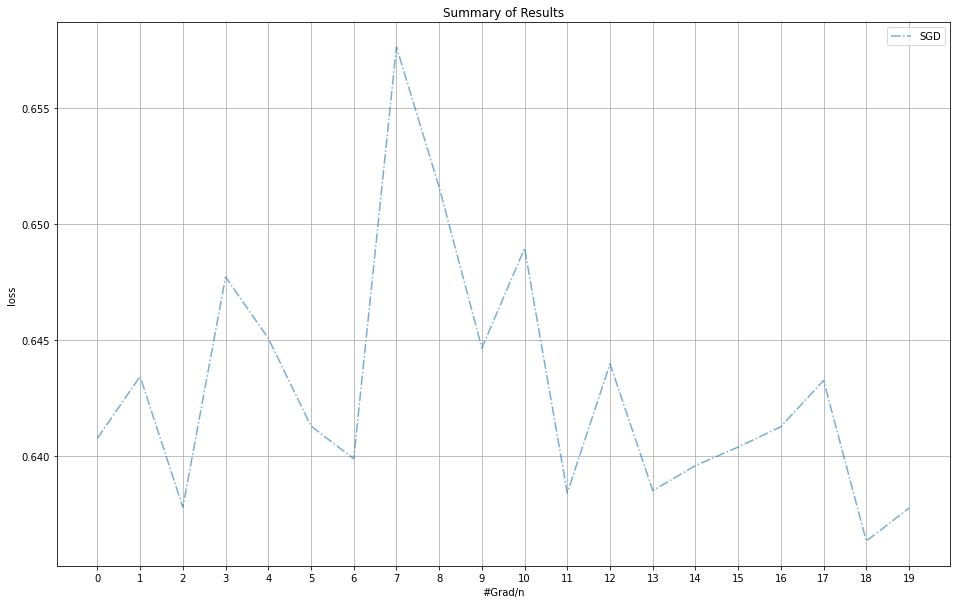

In [276]:
record_graph([record_SGD_single, record_SAG_single, record_SVRG_single, record_SAGA_single],'loss_#Grad/n')

### Minibatch Version (Test Acc)

In [277]:
beta = np.copy(beta_init)

beta_SGD, record_SGD = train_SGD(train_data, train_label, test_data, test_label, beta_init, 0.01, loss_LR, loss_LR_grad, verbose = 1, n_run=20, mb_size=100)

# Grad/N 1: 3.12 seconds, Loss: 0.81, Test Accuracy: 0.689
# Grad/N 2: 5.64 seconds, Loss: 0.75, Test Accuracy: 0.696
# Grad/N 3: 7.82 seconds, Loss: 0.73, Test Accuracy: 0.702
# Grad/N 4: 10.02 seconds, Loss: 0.71, Test Accuracy: 0.707
# Grad/N 5: 12.33 seconds, Loss: 0.70, Test Accuracy: 0.710
# Grad/N 6: 14.52 seconds, Loss: 0.69, Test Accuracy: 0.712
# Grad/N 7: 17.10 seconds, Loss: 0.69, Test Accuracy: 0.714
# Grad/N 8: 19.53 seconds, Loss: 0.69, Test Accuracy: 0.714
# Grad/N 9: 21.87 seconds, Loss: 0.68, Test Accuracy: 0.716
# Grad/N 10: 24.43 seconds, Loss: 0.68, Test Accuracy: 0.716
# Grad/N 11: 26.80 seconds, Loss: 0.68, Test Accuracy: 0.717
# Grad/N 12: 29.07 seconds, Loss: 0.67, Test Accuracy: 0.717
# Grad/N 13: 31.54 seconds, Loss: 0.67, Test Accuracy: 0.717
# Grad/N 14: 33.87 seconds, Loss: 0.67, Test Accuracy: 0.718
# Grad/N 15: 36.78 seconds, Loss: 0.67, Test Accuracy: 0.718
# Grad/N 16: 39.09 seconds, Loss: 0.67, Test Accuracy: 0.718
# Grad/N 17: 41.20 seconds, Loss: 0.

In [278]:
# SAG
beta = np.copy(beta_init)

beta_SAG, record_SAG = train_SAG(train_data, train_label, test_data, test_label, beta_init, 0.01, loss_LR, loss_LR_grad, verbose = 1, n_run=20, mb_size=100)

In [279]:
# SVRG
beta = np.copy(beta_init)

beta_SVRG, record_SVRG = train_SVRG(train_data, train_label, test_data, test_label, beta_init, 0.01, loss_LR, loss_LR_grad, verbose = 1, n_run=20, mb_size=100)

In [280]:
# SAGA
beta = np.copy(beta_init)

beta_SAGA, record_SAGA = train_SAGA(train_data, train_label, test_data, test_label, beta_init, 0.01, loss_LR, loss_LR_grad, verbose = 1, n_run=20, mb_size=100)

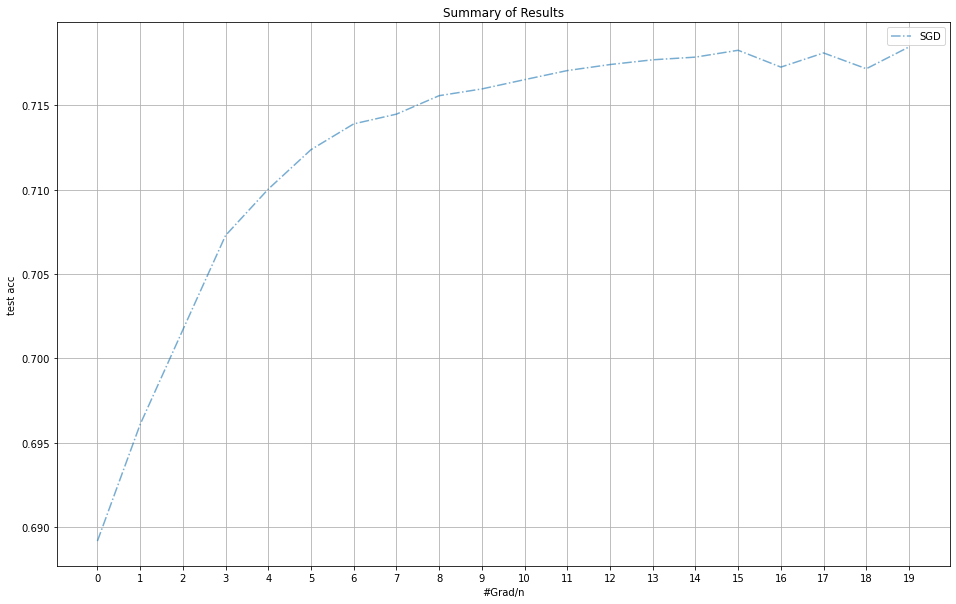

In [281]:
record_graph([record_SGD, record_SAG, record_SVRG, record_SAGA],'test_acc_#Grad/n')

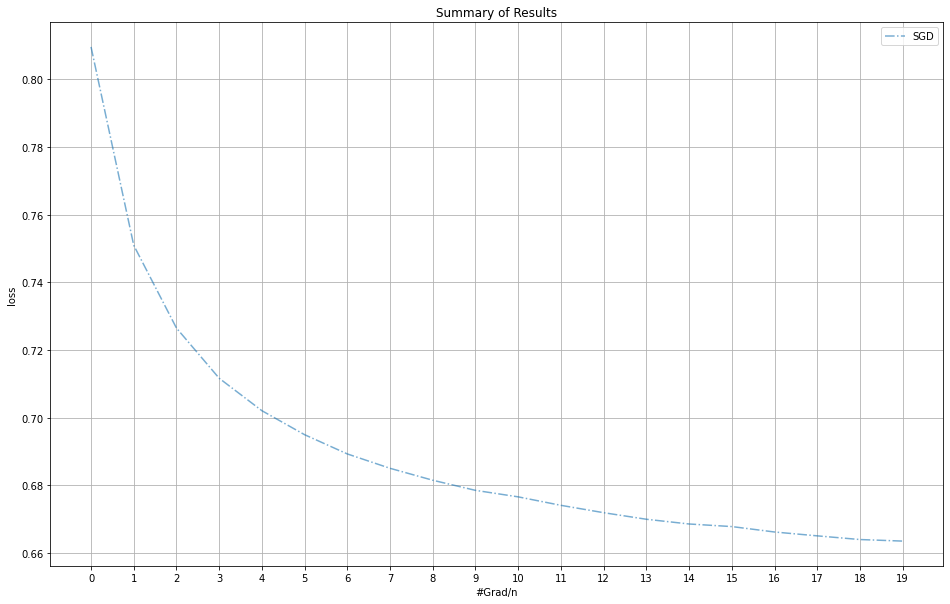

In [282]:
record_graph([record_SGD, record_SAG, record_SVRG, record_SAGA],'loss_#Grad/n')

## Experiment with IJCNN

In [96]:
ijcnn_train_data.shape

(49990, 22)

In [97]:
train_data, test_data, train_label, test_label = ijcnn_train_data, ijcnn_test_data, ijcnn_train_label, ijcnn_test_label

In [98]:
print(np.unique(train_label, return_counts=True))
print(np.unique(test_label, return_counts=True))
print(train_data.shape)
print(test_data.shape)

(array([0, 1], dtype=int32), array([45137,  4853], dtype=int64))
(array([0, 1], dtype=int32), array([82989,  8712], dtype=int64))
(49990, 22)
(91701, 22)


In [99]:
n_features = 22
n_classes = 2
np.random.seed(4212)

beta_init = np.random.normal(0,np.sqrt(1/(n_features)), size=[n_classes, n_features])

In [100]:
beta_init.shape

(2, 22)

#### Optimal Results from Commercial Package

In [120]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='none', solver='lbfgs', fit_intercept=False, max_iter=1000, tol=1e-20)
model.fit(train_data, np.ravel(train_label))

LogisticRegression(fit_intercept=False, max_iter=1000, penalty='none',
                   tol=1e-20)

In [121]:
beta_best = np.zeros(beta_init.shape)
beta_best[0], beta_best[1] = -1*model.coef_, model.coef_
loss_best = loss_LR(beta_best, train_data, train_label)
print(loss_best)

0.24115182


### Single Version (Train Loss)

In [109]:
beta = np.copy(beta_init)

beta_SGD_single, record_SGD_single = train_SGD_single(train_data, train_label, beta_init, 0.01, loss_LR, loss_LR_single_grad, n_run=20, verbose = 1)

# Grad/N 1: 2.15 seconds, Loss: 0.21
# Grad/N 2: 4.79 seconds, Loss: 0.19
# Grad/N 3: 7.69 seconds, Loss: 0.19
# Grad/N 4: 10.66 seconds, Loss: 0.19
# Grad/N 5: 13.33 seconds, Loss: 0.19
# Grad/N 6: 16.10 seconds, Loss: 0.18
# Grad/N 7: 19.19 seconds, Loss: 0.18
# Grad/N 8: 21.85 seconds, Loss: 0.18
# Grad/N 9: 24.89 seconds, Loss: 0.18
# Grad/N 10: 27.90 seconds, Loss: 0.18
# Grad/N 11: 30.68 seconds, Loss: 0.18
# Grad/N 12: 33.86 seconds, Loss: 0.18
# Grad/N 13: 37.47 seconds, Loss: 0.18
# Grad/N 14: 40.29 seconds, Loss: 0.18
# Grad/N 15: 42.96 seconds, Loss: 0.18
# Grad/N 16: 45.66 seconds, Loss: 0.18
# Grad/N 17: 48.37 seconds, Loss: 0.18
# Grad/N 18: 51.16 seconds, Loss: 0.18
# Grad/N 19: 53.97 seconds, Loss: 0.18
# Grad/N 20: 57.32 seconds, Loss: 0.18


In [122]:
# SAG
beta = np.copy(beta_init)

beta_SAG_single, record_SAG_single = train_SAG_single(train_data, train_label, beta_init, 0.01, loss_LR, loss_LR_single_grad, n_run=20, verbose = 1)

# Grad/N 1: 9.08 seconds, Loss: 0.20
# Grad/N 2: 20.70 seconds, Loss: 0.19
# Grad/N 3: 30.59 seconds, Loss: 0.19
# Grad/N 4: 38.50 seconds, Loss: 0.18
# Grad/N 5: 46.22 seconds, Loss: 0.18
# Grad/N 6: 55.97 seconds, Loss: 0.18
# Grad/N 7: 65.21 seconds, Loss: 0.18
# Grad/N 8: 72.43 seconds, Loss: 0.18
# Grad/N 9: 80.08 seconds, Loss: 0.18
# Grad/N 10: 87.22 seconds, Loss: 0.18
# Grad/N 11: 94.12 seconds, Loss: 0.18
# Grad/N 12: 101.35 seconds, Loss: 0.18
# Grad/N 13: 109.42 seconds, Loss: 0.18
# Grad/N 14: 118.01 seconds, Loss: 0.18
# Grad/N 15: 126.08 seconds, Loss: 0.18
# Grad/N 16: 134.28 seconds, Loss: 0.18
# Grad/N 17: 143.38 seconds, Loss: 0.18
# Grad/N 18: 150.72 seconds, Loss: 0.18
# Grad/N 19: 157.94 seconds, Loss: 0.18
# Grad/N 20: 166.36 seconds, Loss: 0.18


In [130]:
# SVRG
beta = np.copy(beta_init)

beta_SVRG_single, record_SVRG_single = train_SVRG_single(train_data, train_label, beta_init, 0.01, loss_LR, loss_LR_single_grad, n_run=10, verbose = 1)

# Grad/N 1: 4.92 seconds, Loss: 0.21
# Grad/N 2: 11.30 seconds, Loss: 0.19
# Grad/N 3: 17.59 seconds, Loss: 0.19
# Grad/N 4: 24.08 seconds, Loss: 0.19
# Grad/N 5: 31.39 seconds, Loss: 0.19
# Grad/N 6: 38.50 seconds, Loss: 0.18
# Grad/N 7: 45.08 seconds, Loss: 0.18
# Grad/N 8: 54.77 seconds, Loss: 0.18
# Grad/N 9: 60.47 seconds, Loss: 0.18
# Grad/N 10: 66.11 seconds, Loss: 0.18
# Grad/N 11: 72.35 seconds, Loss: 0.18
# Grad/N 12: 79.06 seconds, Loss: 0.18
# Grad/N 13: 85.60 seconds, Loss: 0.18
# Grad/N 14: 91.73 seconds, Loss: 0.18
# Grad/N 15: 100.43 seconds, Loss: 0.18
# Grad/N 16: 107.18 seconds, Loss: 0.18
# Grad/N 17: 113.94 seconds, Loss: 0.18
# Grad/N 18: 121.20 seconds, Loss: 0.18
# Grad/N 19: 126.62 seconds, Loss: 0.18
# Grad/N 20: 131.73 seconds, Loss: 0.18


In [131]:
# SAGA
beta = np.copy(beta_init)

beta_SAGA_single, record_SAGA_single = train_SAGA_single(train_data, train_label, beta_init, 0.01, loss_LR, loss_LR_single_grad, n_run=20, verbose = 1)

# Grad/N 1: 24.76 seconds, Loss: 0.21
# Grad/N 2: 48.20 seconds, Loss: 0.19
# Grad/N 3: 68.36 seconds, Loss: 0.19
# Grad/N 4: 92.06 seconds, Loss: 0.19
# Grad/N 5: 114.82 seconds, Loss: 0.19
# Grad/N 6: 134.76 seconds, Loss: 0.18
# Grad/N 7: 154.02 seconds, Loss: 0.18
# Grad/N 8: 173.39 seconds, Loss: 0.18
# Grad/N 9: 199.42 seconds, Loss: 0.18
# Grad/N 10: 224.92 seconds, Loss: 0.18
# Grad/N 11: 249.15 seconds, Loss: 0.18
# Grad/N 12: 276.38 seconds, Loss: 0.18
# Grad/N 13: 299.66 seconds, Loss: 0.18
# Grad/N 14: 321.33 seconds, Loss: 0.18
# Grad/N 15: 343.49 seconds, Loss: 0.18
# Grad/N 16: 368.21 seconds, Loss: 0.18
# Grad/N 17: 391.26 seconds, Loss: 0.18
# Grad/N 18: 415.02 seconds, Loss: 0.18
# Grad/N 19: 437.99 seconds, Loss: 0.18
# Grad/N 20: 460.35 seconds, Loss: 0.18


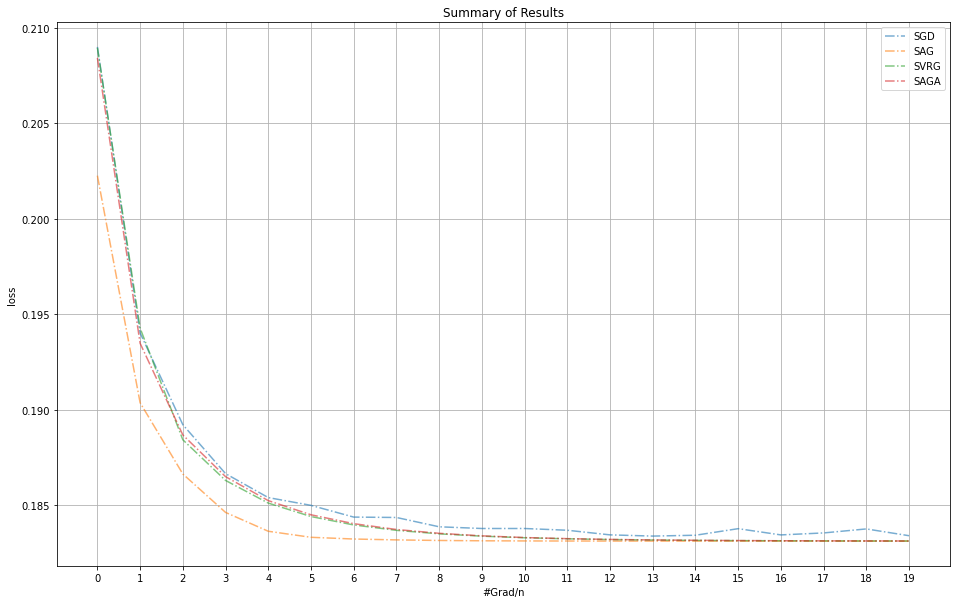

In [132]:
record_graph([record_SGD_single, record_SAG_single, record_SVRG_single, record_SAGA_single],'loss_#Grad/n')
plt.savefig("plot/ijcnn_single_loss.jpg")

### Minibatch Version (Test Acc)

In [144]:
beta = np.copy(beta_init)

beta_SGD, record_SGD = train_SGD(train_data, train_label, test_data, test_label, beta_init, 0.01, loss_LR, loss_LR_grad, verbose = 1, n_run=20, mb_size=100)

# Grad/N 1: 1.05 seconds, Loss: 0.49, Test Accuracy: 0.895
# Grad/N 2: 2.25 seconds, Loss: 0.41, Test Accuracy: 0.905
# Grad/N 3: 3.52 seconds, Loss: 0.38, Test Accuracy: 0.905
# Grad/N 4: 4.83 seconds, Loss: 0.35, Test Accuracy: 0.905
# Grad/N 5: 6.11 seconds, Loss: 0.34, Test Accuracy: 0.905
# Grad/N 6: 7.39 seconds, Loss: 0.33, Test Accuracy: 0.905
# Grad/N 7: 8.66 seconds, Loss: 0.33, Test Accuracy: 0.905
# Grad/N 8: 9.92 seconds, Loss: 0.32, Test Accuracy: 0.905
# Grad/N 9: 11.43 seconds, Loss: 0.32, Test Accuracy: 0.905
# Grad/N 10: 13.42 seconds, Loss: 0.31, Test Accuracy: 0.905
# Grad/N 11: 15.99 seconds, Loss: 0.31, Test Accuracy: 0.905
# Grad/N 12: 18.15 seconds, Loss: 0.30, Test Accuracy: 0.905
# Grad/N 13: 19.84 seconds, Loss: 0.30, Test Accuracy: 0.905
# Grad/N 14: 21.27 seconds, Loss: 0.30, Test Accuracy: 0.905
# Grad/N 15: 22.59 seconds, Loss: 0.30, Test Accuracy: 0.905
# Grad/N 16: 23.86 seconds, Loss: 0.29, Test Accuracy: 0.905
# Grad/N 17: 25.09 seconds, Loss: 0.29, T

In [145]:
# SAG
beta = np.copy(beta_init)

beta_SAG, record_SAG = train_SAG(train_data, train_label, test_data, test_label, beta_init, 0.01, loss_LR, loss_LR_grad, verbose = 1, n_run=20, mb_size=100)

# Grad/N 1: 1.19 seconds, Loss: 0.48, Test Accuracy: 0.900
# Grad/N 2: 2.59 seconds, Loss: 0.39, Test Accuracy: 0.905
# Grad/N 3: 3.87 seconds, Loss: 0.36, Test Accuracy: 0.905
# Grad/N 4: 5.14 seconds, Loss: 0.34, Test Accuracy: 0.905
# Grad/N 5: 6.43 seconds, Loss: 0.33, Test Accuracy: 0.905
# Grad/N 6: 8.03 seconds, Loss: 0.32, Test Accuracy: 0.905
# Grad/N 7: 9.69 seconds, Loss: 0.32, Test Accuracy: 0.905
# Grad/N 8: 11.59 seconds, Loss: 0.32, Test Accuracy: 0.905
# Grad/N 9: 13.00 seconds, Loss: 0.31, Test Accuracy: 0.905
# Grad/N 10: 14.28 seconds, Loss: 0.31, Test Accuracy: 0.905
# Grad/N 11: 15.62 seconds, Loss: 0.31, Test Accuracy: 0.905
# Grad/N 12: 17.13 seconds, Loss: 0.30, Test Accuracy: 0.905
# Grad/N 13: 18.75 seconds, Loss: 0.30, Test Accuracy: 0.905
# Grad/N 14: 20.30 seconds, Loss: 0.30, Test Accuracy: 0.905
# Grad/N 15: 21.67 seconds, Loss: 0.29, Test Accuracy: 0.905
# Grad/N 16: 23.31 seconds, Loss: 0.29, Test Accuracy: 0.905
# Grad/N 17: 24.83 seconds, Loss: 0.29, 

In [146]:
# SVRG
beta = np.copy(beta_init)

beta_SVRG, record_SVRG = train_SVRG(train_data, train_label, test_data, test_label, beta_init, 0.01, loss_LR, loss_LR_grad, verbose = 1, n_run=20, mb_size=100)

# Grad/N 1: 1.58 seconds, Loss: 0.49, Test Accuracy: 0.894
# Grad/N 2: 3.20 seconds, Loss: 0.41, Test Accuracy: 0.905
# Grad/N 3: 4.84 seconds, Loss: 0.38, Test Accuracy: 0.905
# Grad/N 4: 6.42 seconds, Loss: 0.35, Test Accuracy: 0.905
# Grad/N 5: 7.97 seconds, Loss: 0.34, Test Accuracy: 0.905
# Grad/N 6: 9.55 seconds, Loss: 0.33, Test Accuracy: 0.905
# Grad/N 7: 11.18 seconds, Loss: 0.33, Test Accuracy: 0.905
# Grad/N 8: 12.79 seconds, Loss: 0.32, Test Accuracy: 0.905
# Grad/N 9: 14.36 seconds, Loss: 0.32, Test Accuracy: 0.905
# Grad/N 10: 15.89 seconds, Loss: 0.31, Test Accuracy: 0.905
# Grad/N 11: 17.53 seconds, Loss: 0.31, Test Accuracy: 0.905
# Grad/N 12: 19.25 seconds, Loss: 0.30, Test Accuracy: 0.905
# Grad/N 13: 20.86 seconds, Loss: 0.30, Test Accuracy: 0.905
# Grad/N 14: 22.41 seconds, Loss: 0.30, Test Accuracy: 0.905
# Grad/N 15: 24.02 seconds, Loss: 0.30, Test Accuracy: 0.905
# Grad/N 16: 26.00 seconds, Loss: 0.29, Test Accuracy: 0.905
# Grad/N 17: 27.65 seconds, Loss: 0.29,

In [136]:
# SAGA
beta = np.copy(beta_init)

beta_SAGA, record_SAGA = train_SAGA(train_data, train_label, test_data, test_label, beta_init, 0.01, loss_LR, loss_LR_grad, verbose = 1, n_run=20, mb_size=100)

# Grad/N 1: 3.99 seconds, Loss: 0.49, Test Accuracy: 0.894
# Grad/N 2: 7.48 seconds, Loss: 0.41, Test Accuracy: 0.905
# Grad/N 3: 10.93 seconds, Loss: 0.38, Test Accuracy: 0.905
# Grad/N 4: 14.55 seconds, Loss: 0.36, Test Accuracy: 0.905
# Grad/N 5: 18.62 seconds, Loss: 0.34, Test Accuracy: 0.905
# Grad/N 6: 22.31 seconds, Loss: 0.33, Test Accuracy: 0.905
# Grad/N 7: 26.00 seconds, Loss: 0.33, Test Accuracy: 0.905
# Grad/N 8: 29.21 seconds, Loss: 0.32, Test Accuracy: 0.905
# Grad/N 9: 32.61 seconds, Loss: 0.32, Test Accuracy: 0.905
# Grad/N 10: 36.36 seconds, Loss: 0.31, Test Accuracy: 0.905
# Grad/N 11: 40.42 seconds, Loss: 0.31, Test Accuracy: 0.905
# Grad/N 12: 43.50 seconds, Loss: 0.30, Test Accuracy: 0.905
# Grad/N 13: 47.16 seconds, Loss: 0.30, Test Accuracy: 0.905
# Grad/N 14: 50.92 seconds, Loss: 0.30, Test Accuracy: 0.905
# Grad/N 15: 53.90 seconds, Loss: 0.30, Test Accuracy: 0.905
# Grad/N 16: 57.54 seconds, Loss: 0.29, Test Accuracy: 0.905
# Grad/N 17: 61.31 seconds, Loss: 0

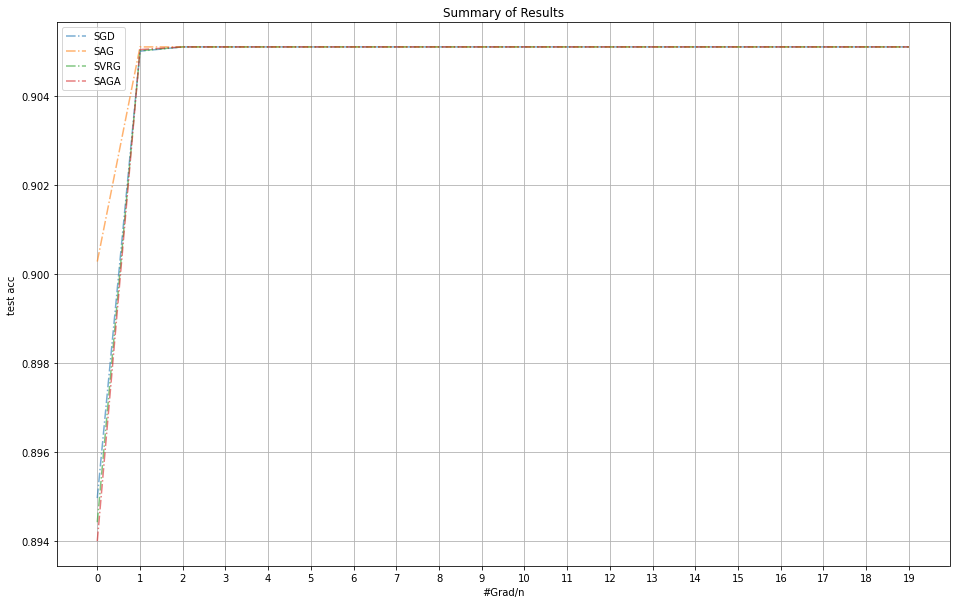

In [147]:
record_graph([record_SGD, record_SAG, record_SVRG, record_SAGA],'test_acc_#Grad/n')
plt.savefig("plot/ijcnn_batch_acc.jpg")

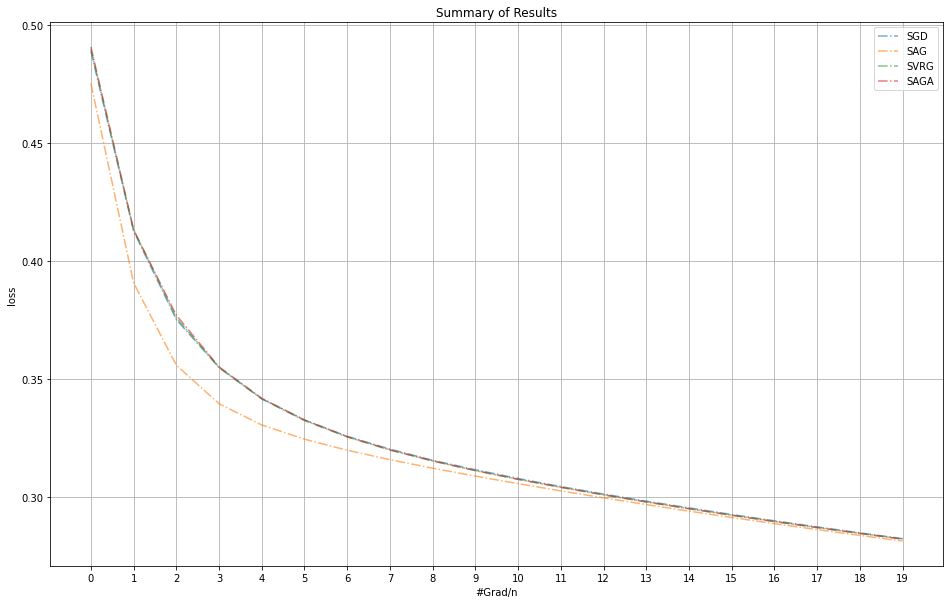

In [148]:
record_graph([record_SGD, record_SAG, record_SVRG, record_SAGA],'loss_#Grad/n')
plt.savefig("plot/ijcnn_batch_loss.jpg")

## Experiment with MNIST

In [245]:
mnist_train_images.shape

(60000, 28, 28)

In [248]:
train_data, test_data, train_label, test_label = mnist_train_images.reshape(-1,28*28), mnist_test_images.reshape(-1,28*28), mnist_train_labels, mnist_test_labels

In [249]:
print(np.unique(train_label, return_counts=True))
print(np.unique(test_label, return_counts=True))
print(train_data.shape)
print(test_data.shape)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
      dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009],
      dtype=int64))
(60000, 784)
(10000, 784)


In [246]:
n_features = 28*28
n_classes = 10
np.random.seed(4212)

beta_init = np.random.normal(0,np.sqrt(1/(n_features)), size=[n_classes, n_features])

In [247]:
beta_init.shape

(10, 784)

#### Optimal Results from Commercial Package

In [120]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='none', solver='lbfgs', fit_intercept=False, max_iter=1000, tol=1e-20)
model.fit(train_data, np.ravel(train_label))

LogisticRegression(fit_intercept=False, max_iter=1000, penalty='none',
                   tol=1e-20)

In [121]:
beta_best = np.zeros(beta_init.shape)
beta_best[0], beta_best[1] = -1*model.coef_, model.coef_
loss_best = loss_LR(beta_best, train_data, train_label)
print(loss_best)

0.24115182


### Single Version (Grad Var and Train Loss)

In [250]:
beta = np.copy(beta_init)

beta_SGD_single, record_SGD_single = train_SGD_single(train_data, train_label, beta_init, 0.01, loss_LR, loss_LR_single_grad, n_run=20, verbose = 1)

# Grad/N 1: 3.50 seconds, Loss: 0.31
# Grad/N 2: 6.38 seconds, Loss: 0.29
# Grad/N 3: 9.36 seconds, Loss: 0.28
# Grad/N 4: 12.48 seconds, Loss: 0.28
# Grad/N 5: 15.37 seconds, Loss: 0.30
# Grad/N 6: 18.27 seconds, Loss: 0.28
# Grad/N 7: 21.54 seconds, Loss: 0.28
# Grad/N 8: 24.86 seconds, Loss: 0.27
# Grad/N 9: 27.81 seconds, Loss: 0.28
# Grad/N 10: 31.20 seconds, Loss: 0.28
# Grad/N 11: 34.86 seconds, Loss: 0.28
# Grad/N 12: 37.99 seconds, Loss: 0.28
# Grad/N 13: 41.20 seconds, Loss: 0.26
# Grad/N 14: 44.94 seconds, Loss: 0.27
# Grad/N 15: 49.04 seconds, Loss: 0.27
# Grad/N 16: 52.56 seconds, Loss: 0.26
# Grad/N 17: 55.73 seconds, Loss: 0.26
# Grad/N 18: 58.81 seconds, Loss: 0.26
# Grad/N 19: 61.99 seconds, Loss: 0.25
# Grad/N 20: 65.30 seconds, Loss: 0.26


In [273]:
# SAG
beta = np.copy(beta_init)

beta_SAG_single, record_SAG_single = train_SAG_single(train_data, train_label, beta_init, 0.01, loss_LR, loss_LR_single_grad, n_run=20, verbose = 1)

In [274]:
# SVRG
beta = np.copy(beta_init)

beta_SVRG_single, record_SVRG_single = train_SVRG_single(train_data, train_label, beta_init, 0.01, loss_LR, loss_LR_single_grad, n_run=20, verbose = 1)

In [275]:
# SAGA
beta = np.copy(beta_init)

beta_SAGA_single, record_SAGA_single = train_SAGA_single(train_data, train_label, beta_init, 0.01, loss_LR, loss_LR_single_grad, n_run=20, verbose = 1)

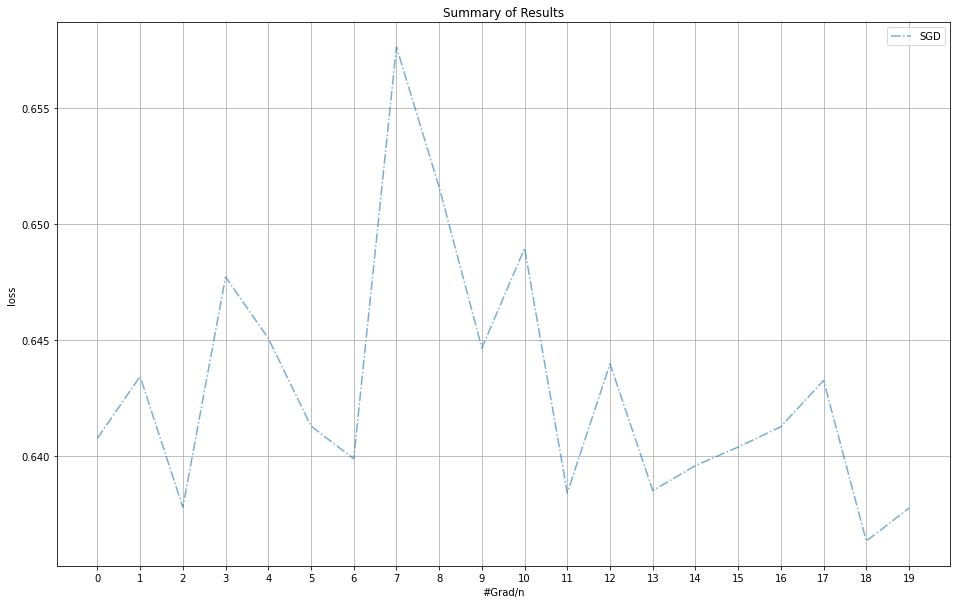

In [276]:
record_graph([record_SGD_single, record_SAG_single, record_SVRG_single, record_SAGA_single],'loss_#Grad/n')
plt.savefig("plot/mnist_single_loss.jpg")

### Minibatch Version (Test Acc)

In [252]:
beta = np.copy(beta_init)

beta_SGD, record_SGD = train_SGD(train_data, train_label, test_data, test_label, beta_init, 0.01, loss_LR, loss_LR_grad, verbose = 1, n_run=20, mb_size=100)

# Grad/N 1: 0.47 seconds, Loss: 0.83, Test Accuracy: 0.789
# Grad/N 2: 0.89 seconds, Loss: 0.67, Test Accuracy: 0.815
# Grad/N 3: 1.29 seconds, Loss: 0.61, Test Accuracy: 0.828
# Grad/N 4: 1.69 seconds, Loss: 0.58, Test Accuracy: 0.832
# Grad/N 5: 2.10 seconds, Loss: 0.56, Test Accuracy: 0.835
# Grad/N 6: 2.57 seconds, Loss: 0.54, Test Accuracy: 0.839
# Grad/N 7: 2.97 seconds, Loss: 0.54, Test Accuracy: 0.840
# Grad/N 8: 3.40 seconds, Loss: 0.53, Test Accuracy: 0.842
# Grad/N 9: 3.82 seconds, Loss: 0.53, Test Accuracy: 0.843
# Grad/N 10: 4.29 seconds, Loss: 0.52, Test Accuracy: 0.844
# Grad/N 11: 4.75 seconds, Loss: 0.52, Test Accuracy: 0.844
# Grad/N 12: 5.21 seconds, Loss: 0.52, Test Accuracy: 0.843
# Grad/N 13: 5.73 seconds, Loss: 0.52, Test Accuracy: 0.844
# Grad/N 14: 6.21 seconds, Loss: 0.52, Test Accuracy: 0.844
# Grad/N 15: 6.70 seconds, Loss: 0.53, Test Accuracy: 0.843
# Grad/N 16: 7.17 seconds, Loss: 0.53, Test Accuracy: 0.843
# Grad/N 17: 7.65 seconds, Loss: 0.53, Test Accur

In [278]:
# SAG
beta = np.copy(beta_init)

beta_SAG, record_SAG = train_SAG(train_data, train_label, test_data, test_label, beta_init, 0.01, loss_LR, loss_LR_grad, verbose = 1, n_run=20, mb_size=100)

In [279]:
# SVRG
beta = np.copy(beta_init)

beta_SVRG, record_SVRG = train_SVRG(train_data, train_label, test_data, test_label, beta_init, 0.01, loss_LR, loss_LR_grad, verbose = 1, n_run=20, mb_size=100)

In [280]:
# SAGA
beta = np.copy(beta_init)

beta_SAGA, record_SAGA = train_SAGA(train_data, train_label, test_data, test_label, beta_init, 0.01, loss_LR, loss_LR_grad, verbose = 1, n_run=20, mb_size=100)

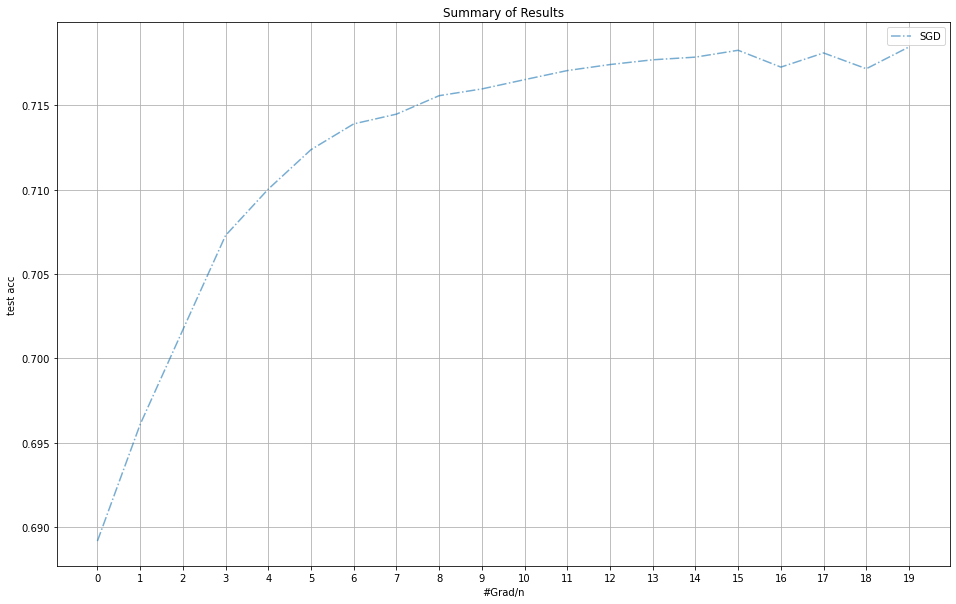

In [281]:
record_graph([record_SGD, record_SAG, record_SVRG, record_SAGA],'test_acc_#Grad/n')
plt.savefig("plot/mnist_batch_acc.jpg")

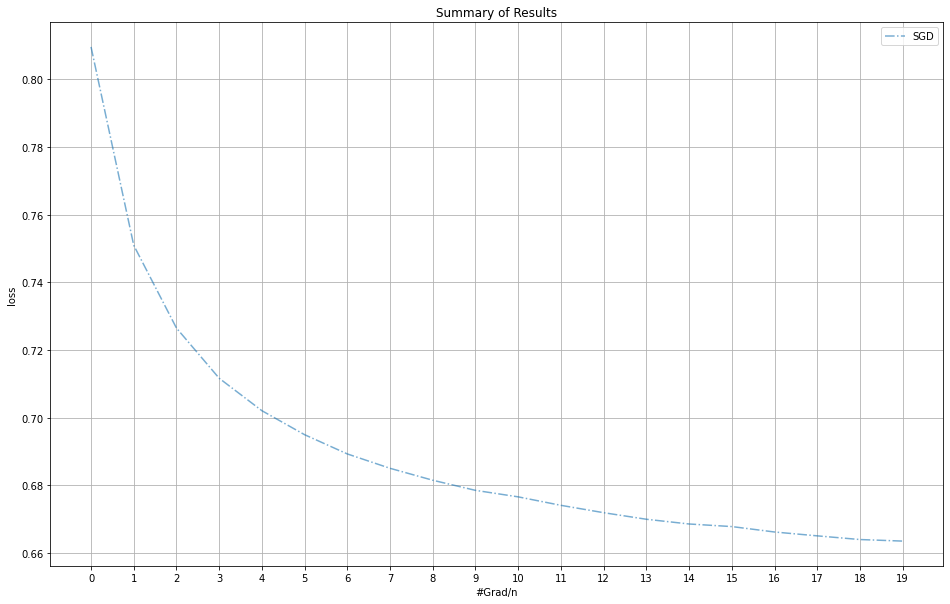

In [282]:
record_graph([record_SGD, record_SAG, record_SVRG, record_SAGA],'loss_#Grad/n')
plt.savefig("plot/mnist_batch_loss.jpg")

## Experiment with Adult

In [258]:
adult_feature_train_norm.shape

(32561, 108)

In [261]:
train_data, test_data, train_label, test_label = adult_feature_train_norm, adult_feature_test_norm, adult_label_train_bi, adult_label_test_bi

In [262]:
print(np.unique(train_label, return_counts=True))
print(np.unique(test_label, return_counts=True))
print(train_data.shape)
print(test_data.shape)

(array([0, 1]), array([24720,  7841], dtype=int64))
(array([0, 1]), array([12435,  3846], dtype=int64))
(32561, 108)
(16281, 108)


In [259]:
n_features = 108
n_classes = 2
np.random.seed(4212)

beta_init = np.random.normal(0,(1/(n_features*n_classes)), size=[n_classes, n_features])

In [260]:
beta_init.shape

(2, 108)

#### Optimal Results from Commercial Package

In [120]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='none', solver='lbfgs', fit_intercept=False, max_iter=1000, tol=1e-20)
model.fit(train_data, np.ravel(train_label))

LogisticRegression(fit_intercept=False, max_iter=1000, penalty='none',
                   tol=1e-20)

In [121]:
beta_best = np.zeros(beta_init.shape)
beta_best[0], beta_best[1] = -1*model.coef_, model.coef_
loss_best = loss_LR(beta_best, train_data, train_label)
print(loss_best)

0.24115182


### Single Version (Grad Var and Train Loss)

In [263]:
beta = np.copy(beta_init)

beta_SGD_single, record_SGD_single = train_SGD_single(train_data, train_label, beta_init, 0.01, loss_LR, loss_LR_single_grad, n_run=20, verbose = 1)

# Grad/N 1: 1.36 seconds, Loss: 0.33
# Grad/N 2: 2.62 seconds, Loss: 0.33
# Grad/N 3: 3.93 seconds, Loss: 0.32
# Grad/N 4: 5.20 seconds, Loss: 0.32
# Grad/N 5: 6.45 seconds, Loss: 0.32
# Grad/N 6: 7.79 seconds, Loss: 0.32
# Grad/N 7: 9.40 seconds, Loss: 0.32
# Grad/N 8: 10.91 seconds, Loss: 0.32
# Grad/N 9: 12.38 seconds, Loss: 0.33
# Grad/N 10: 13.84 seconds, Loss: 0.32
# Grad/N 11: 15.31 seconds, Loss: 0.32
# Grad/N 12: 17.05 seconds, Loss: 0.33
# Grad/N 13: 18.97 seconds, Loss: 0.32
# Grad/N 14: 20.78 seconds, Loss: 0.33
# Grad/N 15: 22.47 seconds, Loss: 0.32
# Grad/N 16: 24.17 seconds, Loss: 0.33
# Grad/N 17: 25.71 seconds, Loss: 0.32
# Grad/N 18: 27.20 seconds, Loss: 0.32
# Grad/N 19: 28.62 seconds, Loss: 0.32
# Grad/N 20: 30.09 seconds, Loss: 0.32


In [273]:
# SAG
beta = np.copy(beta_init)

beta_SAG_single, record_SAG_single = train_SAG_single(train_data, train_label, beta_init, 0.01, loss_LR, loss_LR_single_grad, n_run=20, verbose = 1)

In [274]:
# SVRG
beta = np.copy(beta_init)

beta_SVRG_single, record_SVRG_single = train_SVRG_single(train_data, train_label, beta_init, 0.01, loss_LR, loss_LR_single_grad, n_run=20, verbose = 1)

In [275]:
# SAGA
beta = np.copy(beta_init)

beta_SAGA_single, record_SAGA_single = train_SAGA_single(train_data, train_label, beta_init, 0.01, loss_LR, loss_LR_single_grad, n_run=20, verbose = 1)

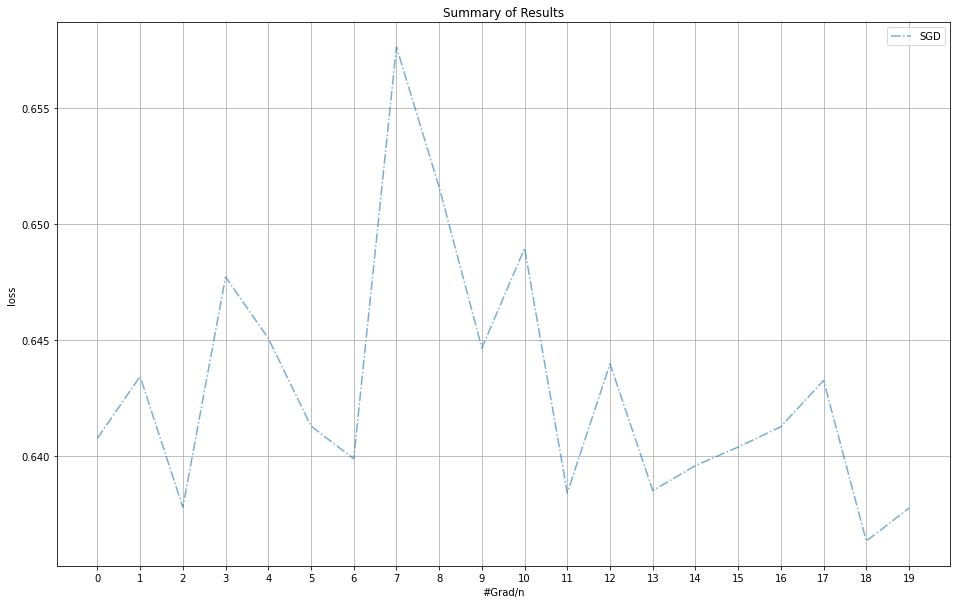

In [276]:
record_graph([record_SGD_single, record_SAG_single, record_SVRG_single, record_SAGA_single],'loss_#Grad/n')

### Minibatch Version (Test Acc)

In [265]:
beta = np.copy(beta_init)

beta_SGD, record_SGD = train_SGD(train_data, train_label, test_data, test_label, beta_init, 0.01, loss_LR, loss_LR_grad, verbose = 1, n_run=20, mb_size=100)

# Grad/N 1: 0.23 seconds, Loss: 0.41, Test Accuracy: 0.711
# Grad/N 2: 0.43 seconds, Loss: 0.38, Test Accuracy: 0.696
# Grad/N 3: 0.64 seconds, Loss: 0.37, Test Accuracy: 0.690
# Grad/N 4: 0.83 seconds, Loss: 0.36, Test Accuracy: 0.685
# Grad/N 5: 1.03 seconds, Loss: 0.36, Test Accuracy: 0.682
# Grad/N 6: 1.22 seconds, Loss: 0.36, Test Accuracy: 0.682
# Grad/N 7: 1.42 seconds, Loss: 0.36, Test Accuracy: 0.680
# Grad/N 8: 1.62 seconds, Loss: 0.35, Test Accuracy: 0.679
# Grad/N 9: 1.82 seconds, Loss: 0.35, Test Accuracy: 0.679
# Grad/N 10: 2.03 seconds, Loss: 0.35, Test Accuracy: 0.678
# Grad/N 11: 2.24 seconds, Loss: 0.35, Test Accuracy: 0.679
# Grad/N 12: 2.42 seconds, Loss: 0.35, Test Accuracy: 0.676
# Grad/N 13: 2.61 seconds, Loss: 0.35, Test Accuracy: 0.677
# Grad/N 14: 2.87 seconds, Loss: 0.35, Test Accuracy: 0.676
# Grad/N 15: 3.07 seconds, Loss: 0.35, Test Accuracy: 0.677
# Grad/N 16: 3.26 seconds, Loss: 0.35, Test Accuracy: 0.677
# Grad/N 17: 3.45 seconds, Loss: 0.35, Test Accur

In [278]:
# SAG
beta = np.copy(beta_init)

beta_SAG, record_SAG = train_SAG(train_data, train_label, test_data, test_label, beta_init, 0.01, loss_LR, loss_LR_grad, verbose = 1, n_run=20, mb_size=100)

In [279]:
# SVRG
beta = np.copy(beta_init)

beta_SVRG, record_SVRG = train_SVRG(train_data, train_label, test_data, test_label, beta_init, 0.01, loss_LR, loss_LR_grad, verbose = 1, n_run=20, mb_size=100)

In [280]:
# SAGA
beta = np.copy(beta_init)

beta_SAGA, record_SAGA = train_SAGA(train_data, train_label, test_data, test_label, beta_init, 0.01, loss_LR, loss_LR_grad, verbose = 1, n_run=20, mb_size=100)

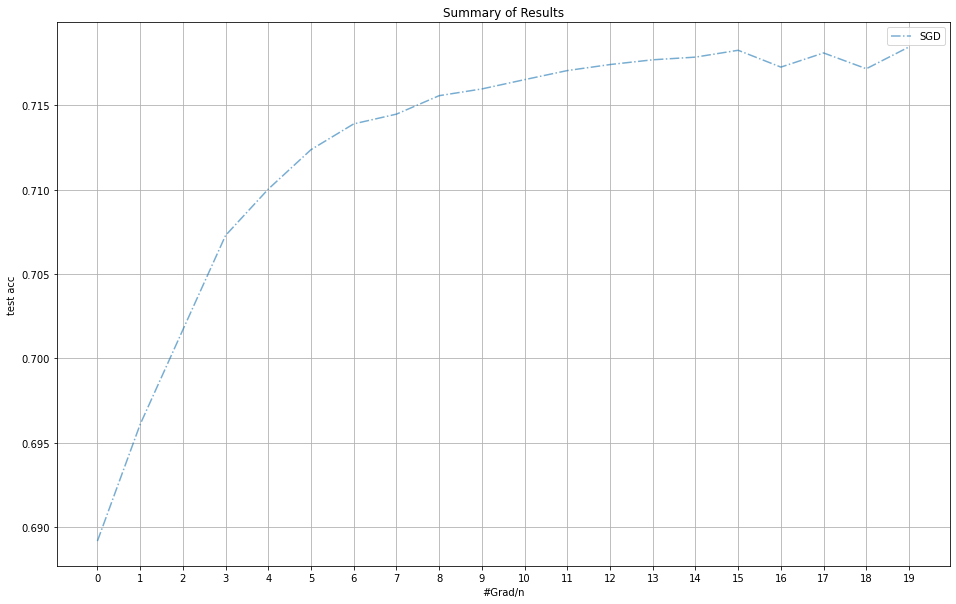

In [281]:
record_graph([record_SGD, record_SAG, record_SVRG, record_SAGA],'test_acc_#Grad/n')

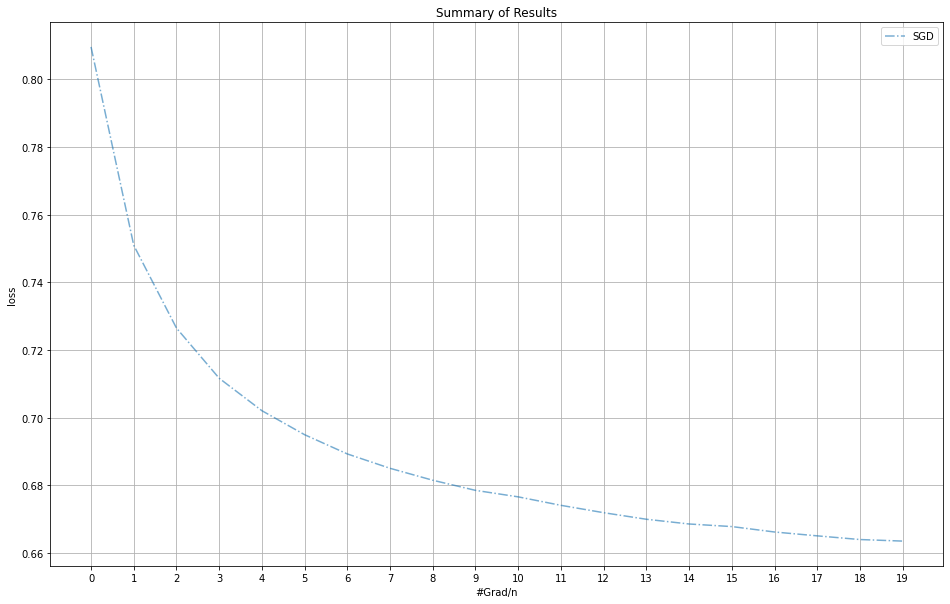

In [282]:
record_graph([record_SGD, record_SAG, record_SVRG, record_SAGA],'loss_#Grad/n')